In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import levene

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

from matplotlib.ticker import FuncFormatter
import warnings

warnings.filterwarnings("ignore")

# Display/Theme setup
pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")

COLORS = ['#BF092F', '#132440', '#16476A', '#3B9797']
sns.set_theme(style="whitegrid", palette=COLORS)
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
})

In [43]:
# Path to merged dataset
df = pd.read_csv("data_clean/merged_dataset.csv")

print("✅ Merged dataset loaded.")
print("Shape:", df.shape)
df.head()

✅ Merged dataset loaded.
Shape: (148, 9)


,Country Code,CountryName,GHG,MF,hale_birth,hale_60,Under5,PPP,World Bank's income classification
0,AFG,Afghanistan,0.796,1.246,50.450,9.880,55.500,"2,210.000",Low-income countries
1,AGO,Angola,1.877,2.938,53.760,11.860,64.000,"7,280.000",Lower-middle-income countries
2,ALB,Albania,2.417,10.037,66.690,15.340,9.400,"20,990.000",Upper-middle-income countries
3,ARE,United Arab Emirates,25.618,39.766,67.270,15.100,5.000,"76,680.000",High-income countries
4,ARG,Argentina,7.949,16.329,64.790,14.990,9.600,"29,460.000",Upper-middle-income countries


## 1. Feature exploration and engineering

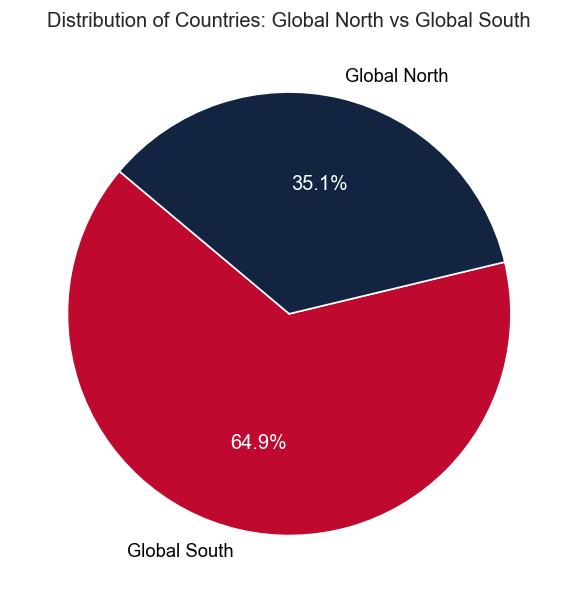

In [44]:
# Create 'Global_region' based on income classification
df['Global_region_num'] = (
    df["World Bank's income classification"]
    .str.lower()
    .str.replace('-', ' ')
    .str.strip()
    .apply(lambda x: 1 if 'high income' in x else 0)
)
df['Global_region'] = df['Global_region_num'].map({1: 'Global North', 0: 'Global South'})

# Pie chart of Global North vs South
region_counts = df['Global_region'].value_counts()
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', colors=COLORS[:2], startangle=140)
plt.setp(autotexts, color='white')   # only percentages white
plt.setp(texts, color='black')       # keep region labels black
plt.title('Distribution of Countries: Global North vs Global South')
plt.show()

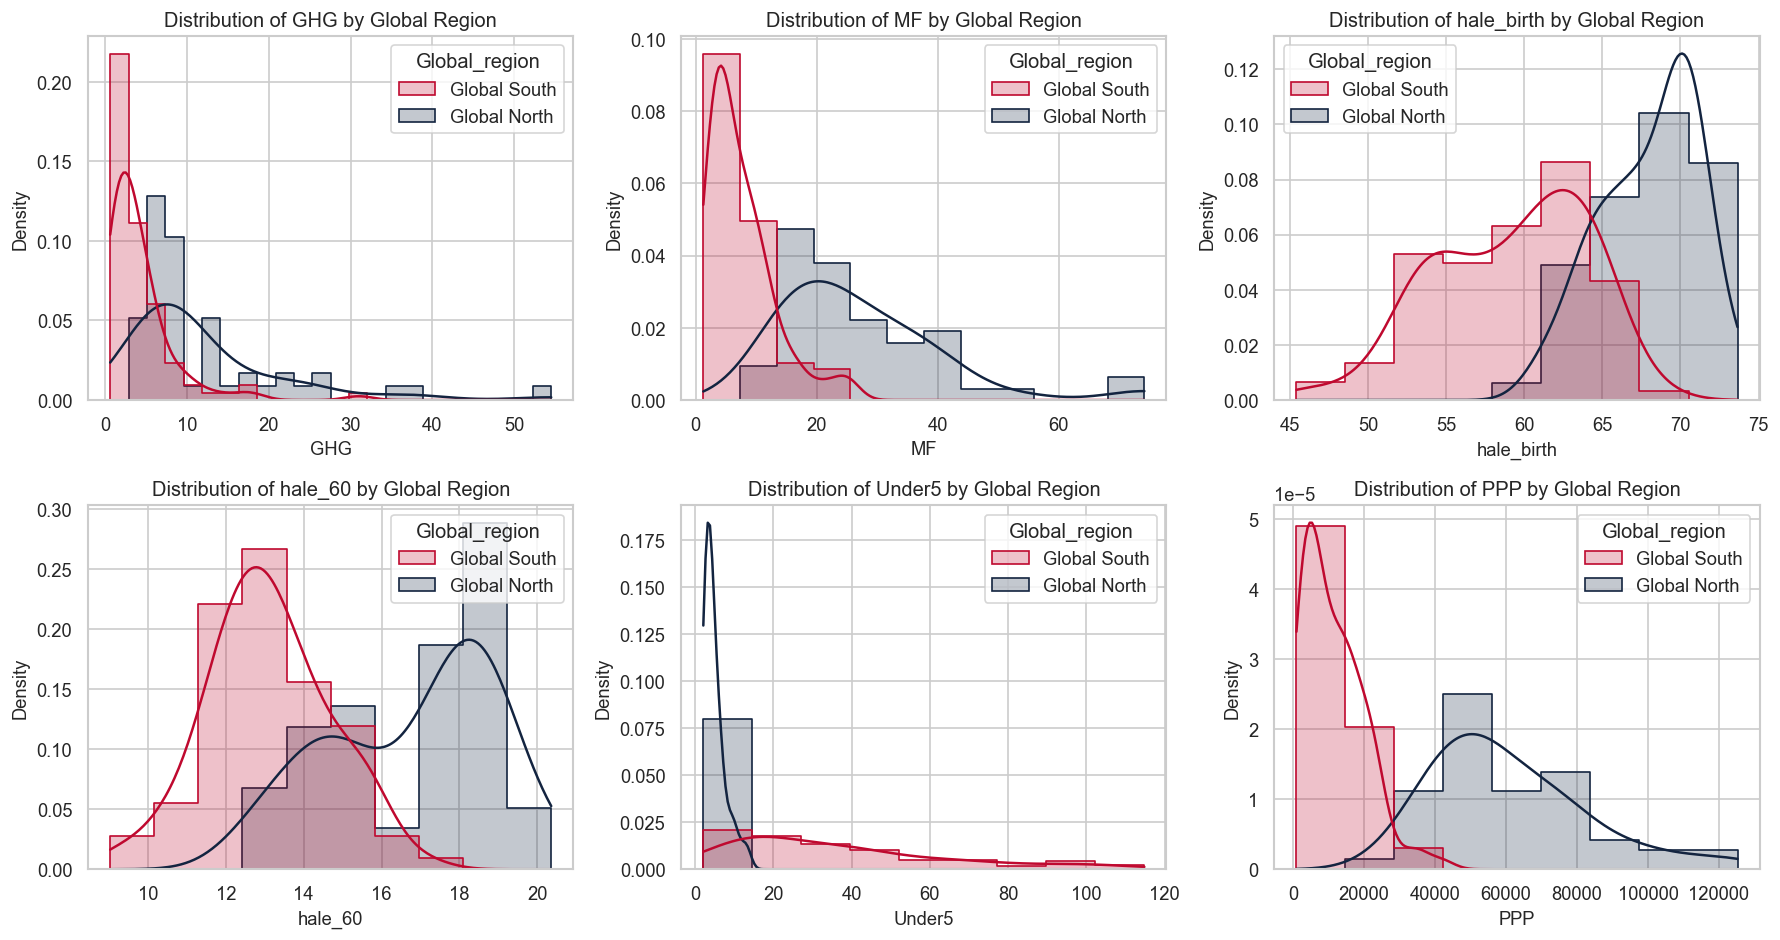

In [45]:
# Historgrams of key indicators by region
key_indicators = ['GHG', 'MF', 'hale_birth', 'hale_60', 'Under5', 'PPP']
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, indicator in enumerate(key_indicators):
    sns.histplot(data=df, x=indicator, hue='Global_region', kde=True, palette=COLORS[:2], element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {indicator} by Global Region')
    axes[i].set_xlabel(indicator)
    axes[i].set_ylabel('Density')
    plt.tight_layout()

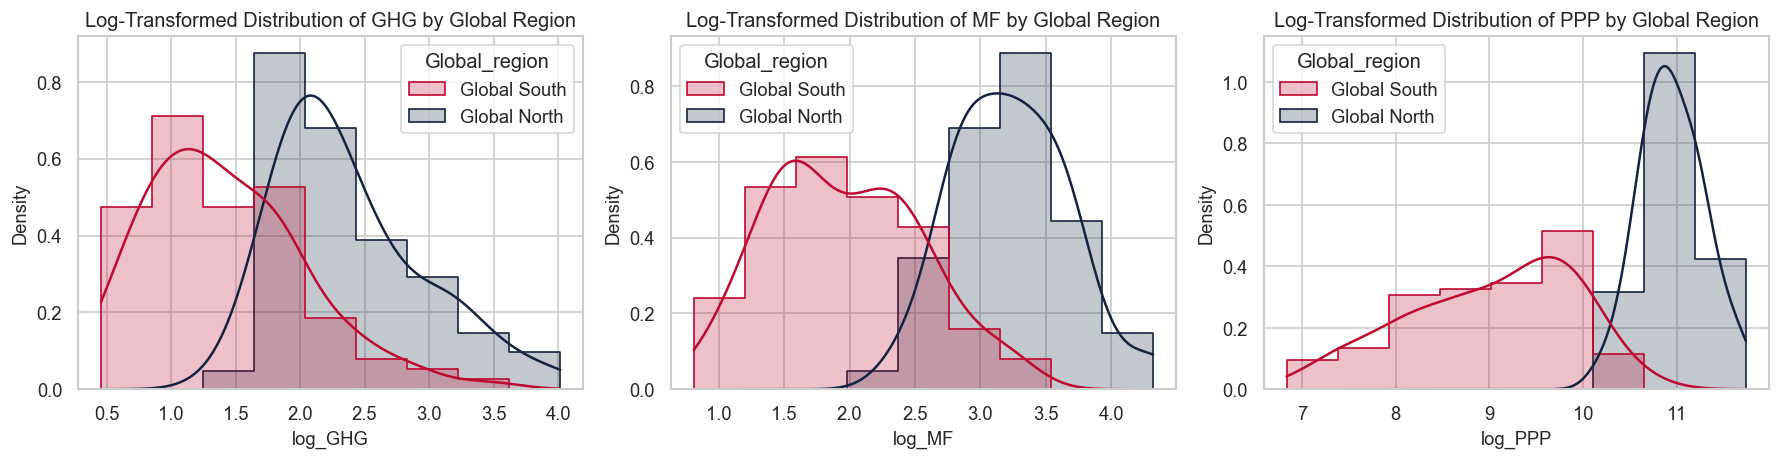

In [46]:
# Log-transform skewed indicators
skewed_indicators = ['GHG', 'MF', 'PPP']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
    
for i, indicator in enumerate(skewed_indicators):
    df[f'log_{indicator}'] = np.log1p(df[indicator])
    sns.histplot(data=df, x=f'log_{indicator}', hue='Global_region', kde=True, palette=COLORS[:2], element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Log-Transformed Distribution of {indicator} by Global Region')
    axes[i].set_xlabel(f'log_{indicator}')
    axes[i].set_ylabel('Density')
    plt.tight_layout()
plt.show()

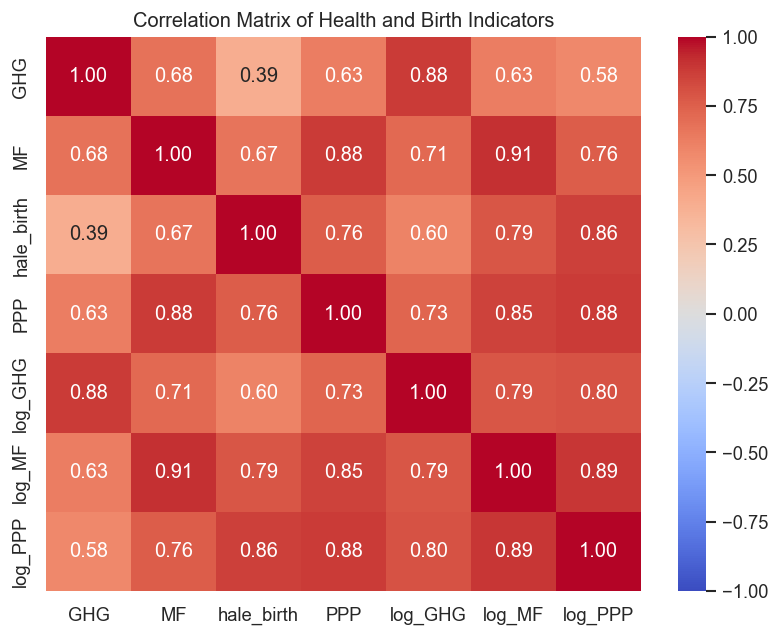

In [47]:
# Correlation matrix
hale_birth_indicators = ['GHG', 'MF', 'hale_birth', 'PPP', 'log_GHG', 'log_MF', 'log_PPP']
corr_matrix = df[hale_birth_indicators].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Health and Birth Indicators')
plt.show()

In [48]:
# Standardize indicators for regression
scaler = StandardScaler()
indicators_to_scale = ['log_GHG', 'log_MF', 'log_PPP']
df_scaled = df.copy()
df_scaled[indicators_to_scale] = scaler.fit_transform(df_scaled[indicators_to_scale])

## 2. Baseline modelling

### 2.1 OLS regression b/w health & consumption

                            OLS Regression Results                            
Dep. Variable:             hale_birth   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     239.3
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.42e-32
Time:                        16:30:26   Log-Likelihood:                -404.57
No. Observations:                 148   AIC:                             813.1
Df Residuals:                     146   BIC:                             819.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.2786      0.308    202.108      0.0

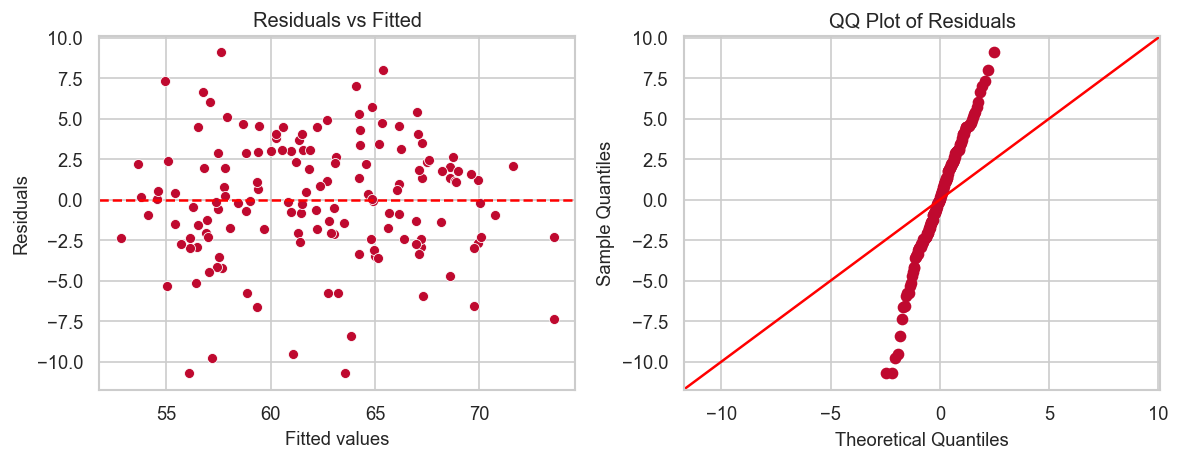

In [49]:
# OLS regression b/w health & consumption
model_formula = 'hale_birth ~ log_MF'
ols_model = smf.ols(formula=model_formula, data=df_scaled).fit()
print(ols_model.summary())
# Residual plots
residuals = ols_model.resid
fitted = ols_model.fittedvalues
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=fitted, y=residuals, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
sm.qqplot(residuals, line='45', ax=axes[1])
axes[1].set_title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()


R² = 0.62, highly significant (p < 0.001). <br>
β ≈ 4.77: each 1 SD increase in log MF → ≈ 4.8 year increase in healthy life expectancy.<br> 
Residuals roughly homoscedastic; mild non-normal tails.

### 2.2 Multivariate model for health

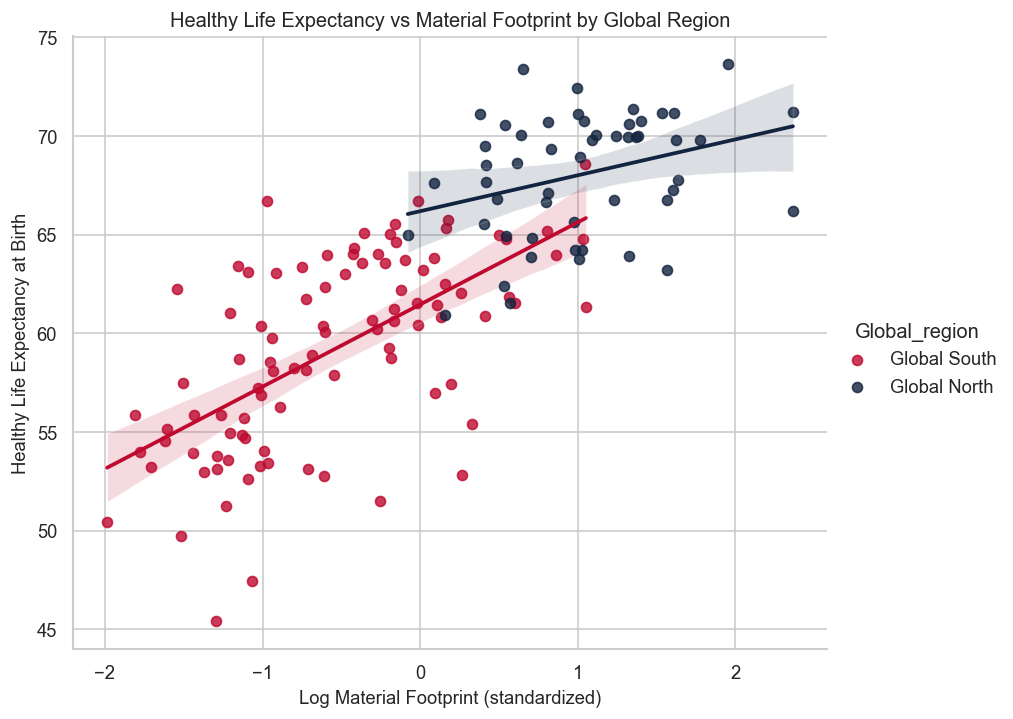

                            OLS Regression Results                            
Dep. Variable:             hale_birth   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     159.7
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.34e-45
Time:                        16:30:26   Log-Likelihood:                -368.00
No. Observations:                 148   AIC:                             744.0
Df Residuals:                     144   BIC:                             756.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.2786      0.242    256.978      0.0

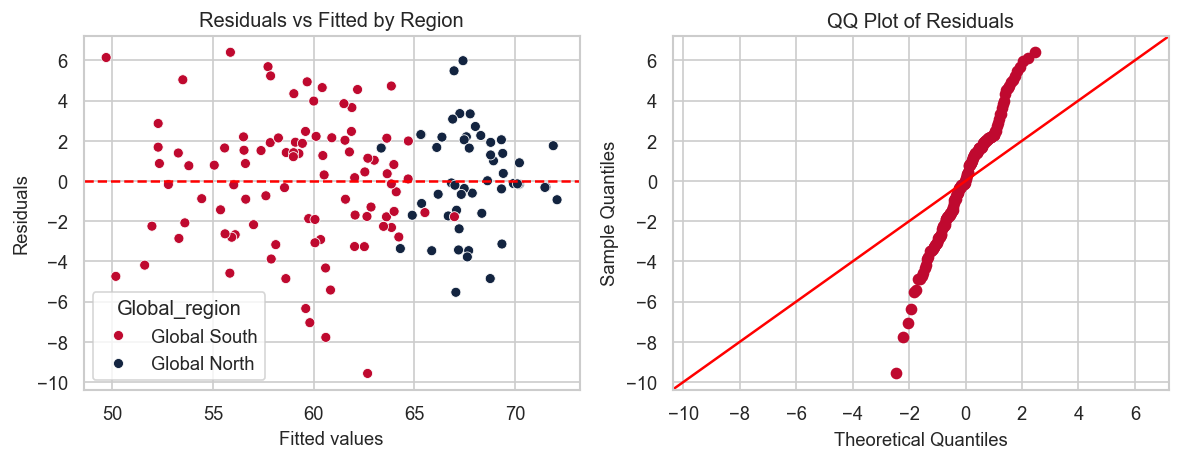

Levene's test statistic: 4.047, p-value: 0.046
=> Variances are significantly different between groups


In [50]:
# MF vs hale_birth by region scatter plot
sns.lmplot(x='log_MF', y='hale_birth', hue='Global_region', data=df_scaled, palette=COLORS[:2], height=6, aspect=1.2)
plt.title('Healthy Life Expectancy vs Material Footprint by Global Region')
plt.xlabel('Log Material Footprint (standardized)')
plt.ylabel('Healthy Life Expectancy at Birth')
plt.show()

# OLS regression b/w health & other factors
model_formula_multi = 'hale_birth ~ log_MF + log_GHG + log_PPP'
ols_model_multi = smf.ols(formula=model_formula_multi, data=df_scaled).fit()
print(ols_model_multi.summary())
# Residual plots by region
residuals_multi = ols_model_multi.resid
fitted_multi = ols_model_multi.fittedvalues
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=fitted_multi, y=residuals_multi, hue=df_scaled['Global_region'], palette=COLORS[:2], ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted by Region')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
sm.qqplot(residuals_multi, line='45', ax=axes[1])
axes[1].set_title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()
# Levene's test for homogeneity of variance (use scipy.stats.levene)
levene_stat, levene_p = levene(
    residuals_multi[df_scaled['Global_region'] == 'Global North'],
    residuals_multi[df_scaled['Global_region'] == 'Global South']
)
print(f"Levene's test statistic: {levene_stat:.3f}, p-value: {levene_p:.3f}")
if levene_p < 0.05:
    print("=> Variances are significantly different between groups")
else:
    print("=> No significant difference in variances between groups")


Adj R² = 0.76 (↑ from 0.62) → model fit improves notably.<br>
log_MF = +1.19 (p = 0.035) → MF still matters, but weaker.<br>
log_GHG = –1.76 (p < 0.001) → higher emissions correlate with lower health.<br>
log_PPP = +5.55 (p < 0.001) → income is the strongest positive driver.<br>
Once wealth and emissions are controlled, MF’s direct benefit on health diminishes—its apparent effect in Model 1 was partly income-related. The negative GHG coefficient suggests environmental degradation offsets some health gains.<br>
Residuals acceptable; slight right-tail deviation.<br>
Levene’s test p = 0.046 → heteroskedasticity between regions—variance differs across North/South.

### 2.3 Include Global North-South interaction (H1a)

                            OLS Regression Results                            
Dep. Variable:             hale_birth   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     93.25
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.40e-33
Time:                        16:30:27   Log-Likelihood:                -396.52
No. Observations:                 148   AIC:                             801.0
Df Residuals:                     144   BIC:                             813.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            61.4614      0.46

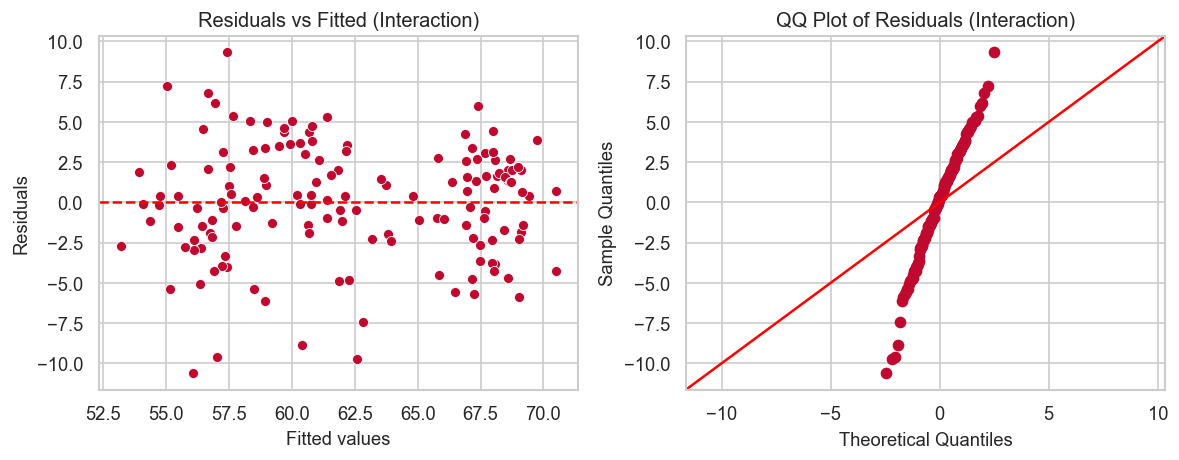


Variance Inflation Factor (VIF) with Interaction:
             feature   VIF
0             log_MF 1.886
1  Global_region_num 4.650
2    MF_GlobalRegion 5.536


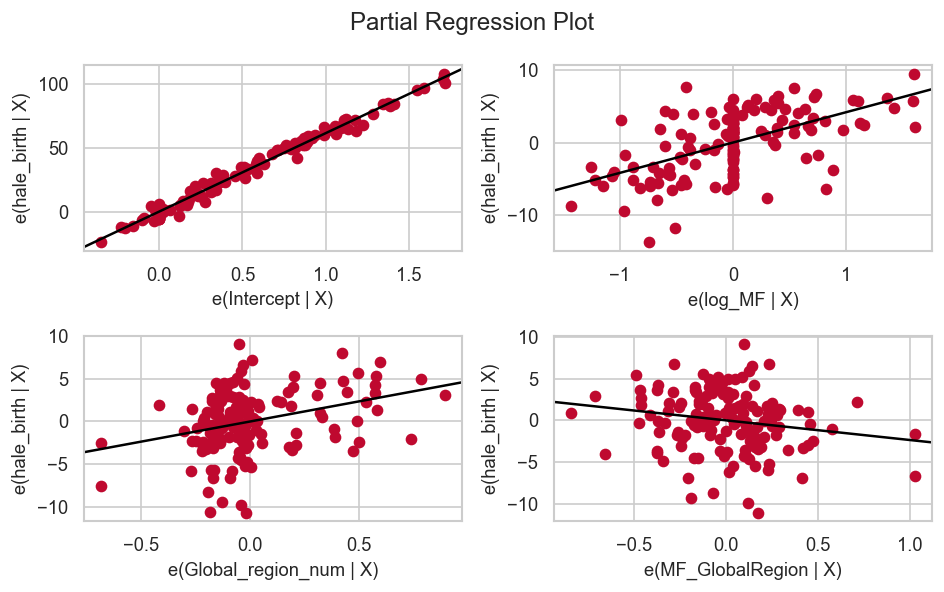

In [51]:
# Interaction term
df_scaled['MF_GlobalRegion'] = df_scaled['log_MF'] * df_scaled['Global_region_num']
# OLS regression with interaction
model_formula_interaction = 'hale_birth ~ log_MF + Global_region_num + MF_GlobalRegion'
ols_model_interaction = smf.ols(formula=model_formula_interaction, data=df_scaled).fit()
print(ols_model_interaction.summary())
# Residual plots
residuals_interaction = ols_model_interaction.resid
fitted_interaction = ols_model_interaction.fittedvalues
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=fitted_interaction, y=residuals_interaction, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted (Interaction)')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
sm.qqplot(residuals_interaction, line='45', ax=axes[1])
axes[1].set_title('QQ Plot of Residuals (Interaction)')
plt.tight_layout()
plt.show()
# Check multicollinearity with interaction
X_interaction = df_scaled[['log_MF', 'Global_region_num', 'MF_GlobalRegion']]
vif_data_interaction = pd.DataFrame()
vif_data_interaction['feature'] = X_interaction.columns
vif_data_interaction['VIF'] = [variance_inflation_factor(X_interaction.values, i) for i in range(X_interaction.shape[1])]
print("\nVariance Inflation Factor (VIF) with Interaction:")
print(vif_data_interaction) 
# Partial regression plots with 
fig = sm.graphics.plot_partregress_grid(ols_model_interaction)
fig.tight_layout(pad=1.0)
plt.show()

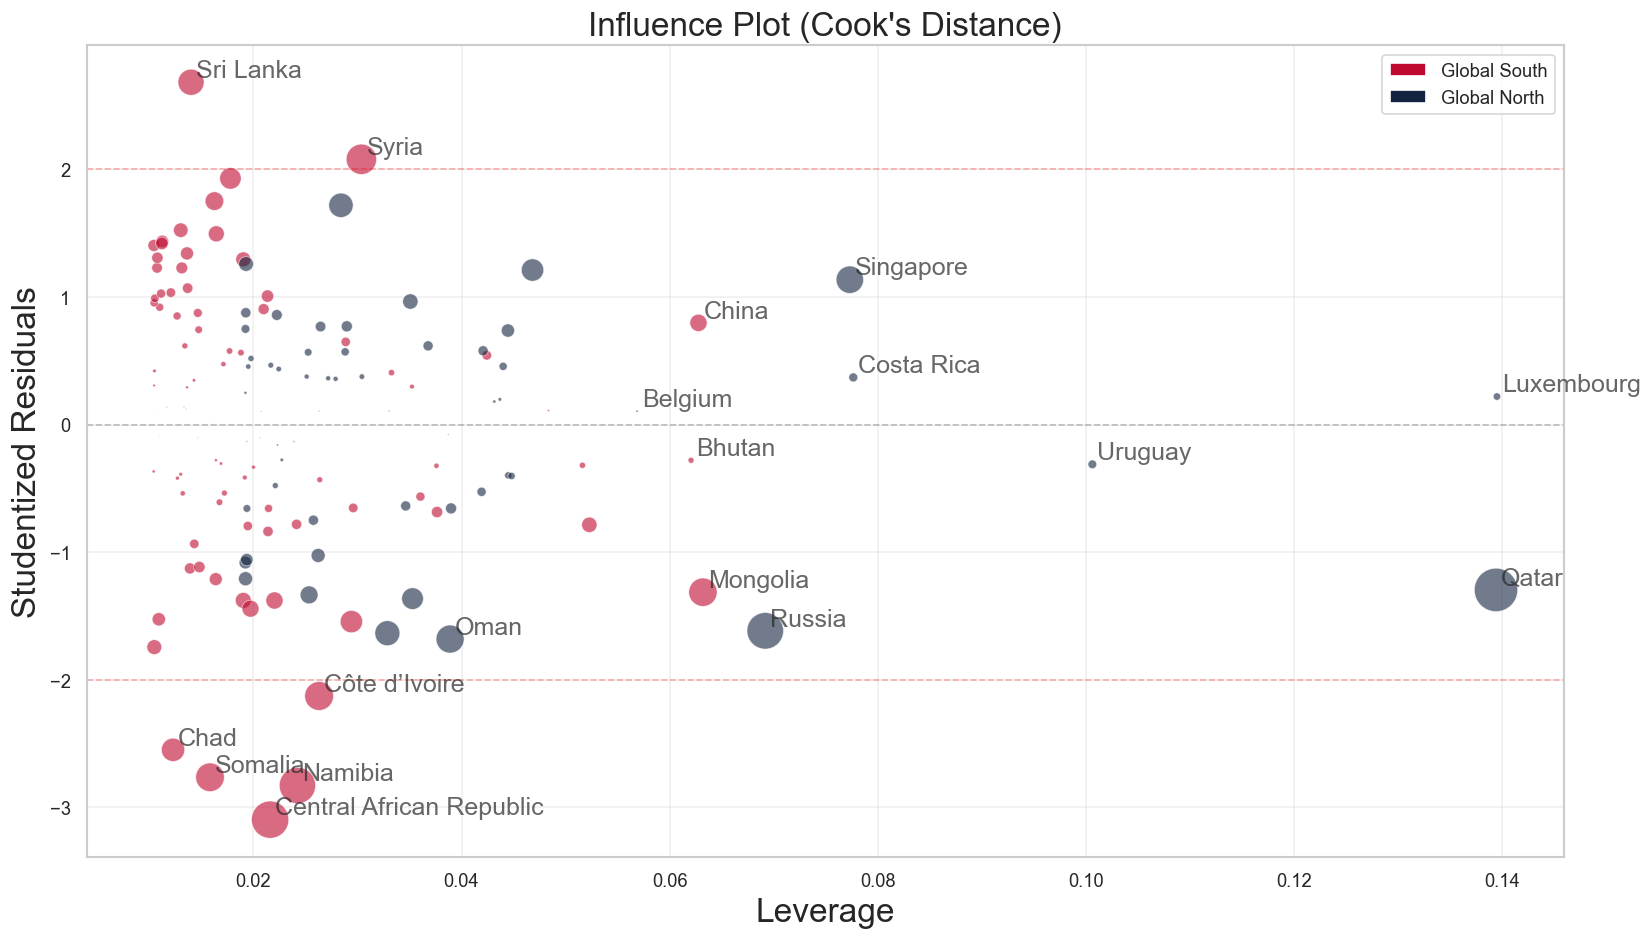

In [52]:
# Influence plot (Cook's distance) by with Country Name labels and colour coded by region
influence = ols_model_interaction.get_influence()
leverage = influence.hat_matrix_diag
studentized_residuals = influence.resid_studentized_external
cooks_d = influence.cooks_distance[0]

fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#BF092F' if region == 'Global South' else '#132440' 
          for region in df_scaled['Global_region']]
scatter = ax.scatter(leverage, studentized_residuals, 
                     s=cooks_d * 10000,  # Size by Cook's distance
                     c=colors, alpha=0.6, edgecolors='white', linewidth=0.5)
cooks_threshold = 4 / len(df_scaled)  # Common threshold
leverage_threshold = 2 * (len(ols_model_interaction.params) / len(df_scaled))  # 2*mean leverage
residual_threshold = 2  # Studentized residuals beyond ±2
outliers = (cooks_d > cooks_threshold) | \
           (leverage > leverage_threshold) | \
           (np.abs(studentized_residuals) > residual_threshold)

for i, country in enumerate(df_scaled['CountryName']):
    if outliers[i]:
        ax.annotate(country, 
                   (leverage[i], studentized_residuals[i]), 
                   fontsize=15, 
                   alpha=0.7,
                   xytext=(3, 3),
                   textcoords='offset points')
ax.axhline(0, linestyle='--', color='gray', alpha=0.5, linewidth=1)
ax.axhline(2, linestyle='--', color='red', alpha=0.3, linewidth=1)
ax.axhline(-2, linestyle='--', color='red', alpha=0.3, linewidth=1)
ax.set_xlabel('Leverage', fontsize=20)
ax.set_ylabel('Studentized Residuals', fontsize=20)
ax.set_title("Influence Plot (Cook's Distance)", fontsize=20)
ax.grid(True, alpha=0.3)
legend_elements = [Patch(facecolor='#BF092F', label='Global South'),
                   Patch(facecolor='#132440', label='Global North')]
ax.legend(handles=legend_elements, loc='best')
plt.tight_layout()
plt.show()

Adj R² = 0.65.<br>
MF × GlobalRegion = –2.35 (p = 0.028): slope weaker in the Global North.<br>
Global North intercept ≈ 4.7 years higher (better baseline health).<br>
VIFs < 6 → tolerable multicollinearity.<br>
MF–health link is significantly stronger in the Global South, where each unit increase in consumption translates to larger health gains. In the Global North, returns to material use on health flatten—consistent with “diminishing returns” once basic welfare is met.<br>
Residuals random and roughly normal.<br>
Partial regression plots confirm small but clear negative slope for the interaction term.<br>

### 2.4 MG-GHG coupling in Global North (H1b)

                            OLS Regression Results                            
Dep. Variable:                log_GHG   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     78.87
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           3.08e-30
Time:                        16:30:28   Log-Likelihood:                -138.07
No. Observations:                 148   AIC:                             284.1
Df Residuals:                     144   BIC:                             296.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

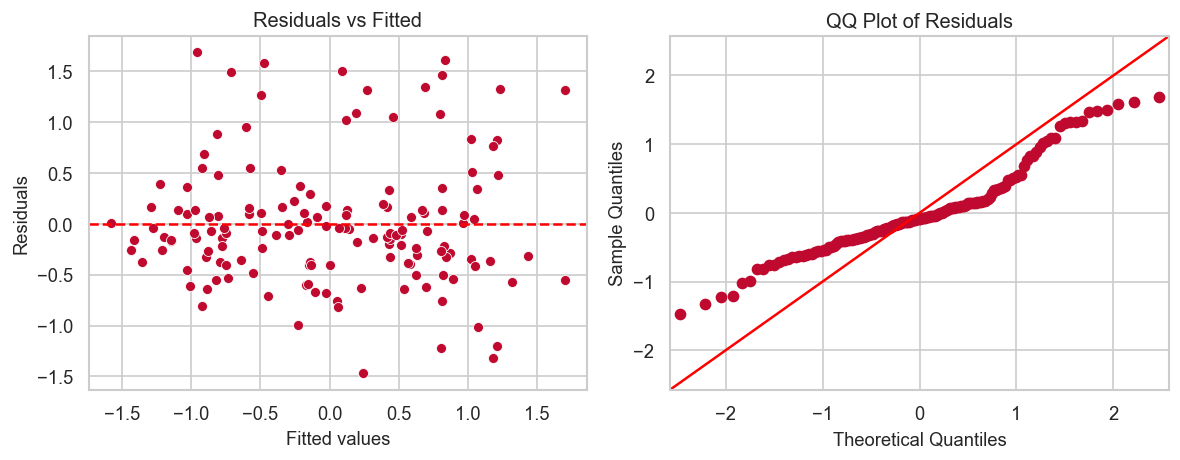


Variance Inflation Factor (VIF) for GHG-MF model:
             feature   VIF
0             log_MF 1.584
1  Global_region_num 1.584


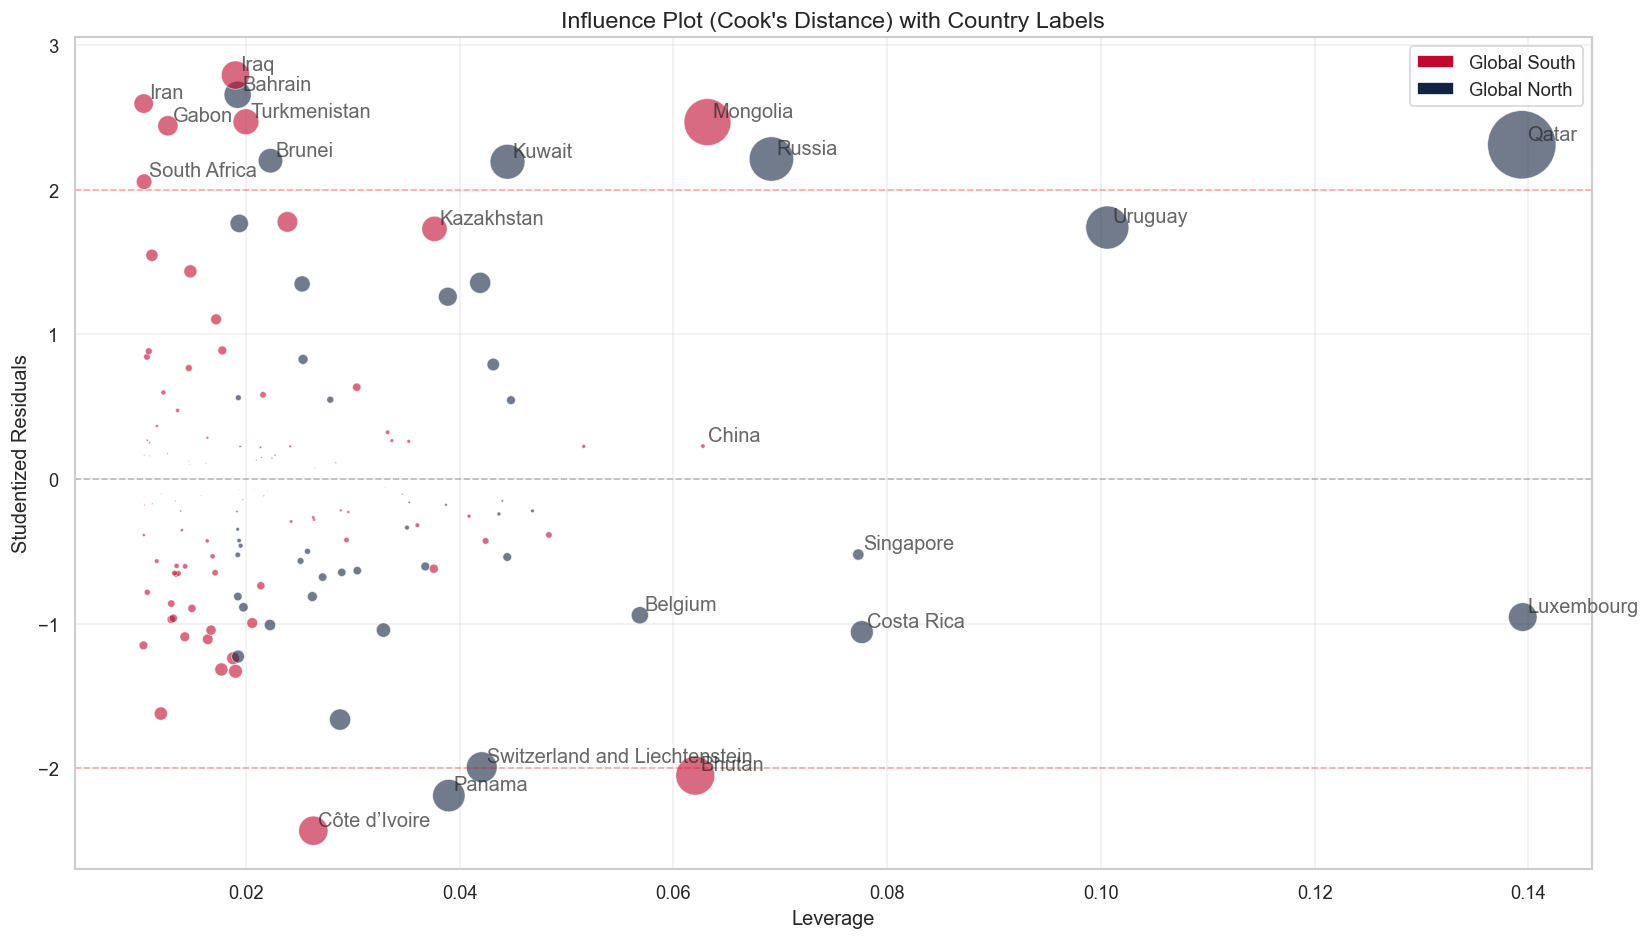

In [53]:
# GHG trade-off with MF
model_formula_ghg = 'log_GHG ~ log_MF + Global_region_num + log_MF:Global_region_num'
ols_model_ghg = smf.ols(formula=model_formula_ghg, data=df_scaled).fit()
print(ols_model_ghg.summary())
# Residual plots
residuals_ghg = ols_model_ghg.resid
fitted_ghg = ols_model_ghg.fittedvalues
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=fitted_ghg, y=residuals_ghg, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
sm.qqplot(residuals_ghg, line='45', ax=axes[1])
axes[1].set_title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()
# Check multicollinearity
X_ghg = df_scaled[['log_MF', 'Global_region_num']]
vif_data_tradeoff = pd.DataFrame()
vif_data_tradeoff['feature'] = X_ghg.columns
vif_data_tradeoff['VIF'] = [variance_inflation_factor(X_ghg.values, i) for i in range(X_ghg.shape[1])]
print("\nVariance Inflation Factor (VIF) for GHG-MF model:")
print(vif_data_tradeoff)

# Influence plot (Cook's distance) by with Country Name labels and colour coded by region
influence = ols_model_ghg.get_influence()
leverage = influence.hat_matrix_diag
studentized_residuals = influence.resid_studentized_external
cooks_d = influence.cooks_distance[0]

fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#BF092F' if region == 'Global South' else '#132440' 
          for region in df_scaled['Global_region']]
scatter = ax.scatter(leverage, studentized_residuals, 
                     s=cooks_d * 8000,  # Size by Cook's distance
                     c=colors, alpha=0.6, edgecolors='white', linewidth=0.5)
cooks_threshold = 4 / len(df_scaled)  # Common threshold
leverage_threshold = 2 * (len(ols_model_ghg.params) / len(df_scaled))  # 2*mean leverage
residual_threshold = 2  # Studentized residuals beyond ±2
outliers = (cooks_d > cooks_threshold) | \
           (leverage > leverage_threshold) | \
           (np.abs(studentized_residuals) > residual_threshold)

for i, country in enumerate(df_scaled['CountryName']):
    if outliers[i]:
        ax.annotate(country, 
                   (leverage[i], studentized_residuals[i]), 
                   fontsize=12, 
                   alpha=0.7,
                   xytext=(3, 3),
                   textcoords='offset points')
ax.axhline(0, linestyle='--', color='gray', alpha=0.5, linewidth=1)
ax.axhline(2, linestyle='--', color='red', alpha=0.3, linewidth=1)
ax.axhline(-2, linestyle='--', color='red', alpha=0.3, linewidth=1)
ax.set_xlabel('Leverage', fontsize=12)
ax.set_ylabel('Studentized Residuals', fontsize=12)
ax.set_title("Influence Plot (Cook's Distance) with Country Labels", fontsize=14)
ax.grid(True, alpha=0.3)
legend_elements = [Patch(facecolor='#BF092F', label='Global South'),
                   Patch(facecolor='#132440', label='Global North')]
ax.legend(handles=legend_elements, loc='best')
plt.tight_layout()
plt.show()

R² = 0.62, similar to baseline health model → material footprint still explains much of the variation in emissions.<br>
log MF = +0.79, p = 0.43 → no significant global relationship once regions are considered.<br>
Interaction (MF × Region) = –0.14, p = 0.45 → no statistically significant difference in MF–GHG slope between North and South.<br>
Residuals: roughly homoscedastic, no pattern in residual–fitted plot.<br>
Normality: some deviation at tails (Omnibus p < 0.01), but acceptable for cross-country data.<br>
VIF ≈ 1.6 → no multicollinearity issues.<br>
Material footprint and emissions are positively associated in general, but the North–South contrast is not significant.
In both regions, increases in consumption tend to raise GHG emissions, yet the magnitude of coupling is statistically similar.

Supports H1b, partial for H1c. Suggests the GHG–MF relationship is globally proportional rather than region-specific; industrial efficiency differences may be offset by scale.

### 2.5 Trade-off model

                            OLS Regression Results                            
Dep. Variable:             hale_birth   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     70.07
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           9.71e-33
Time:                        16:33:17   Log-Likelihood:                -396.08
No. Observations:                 148   AIC:                             802.2
Df Residuals:                     143   BIC:                             817.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

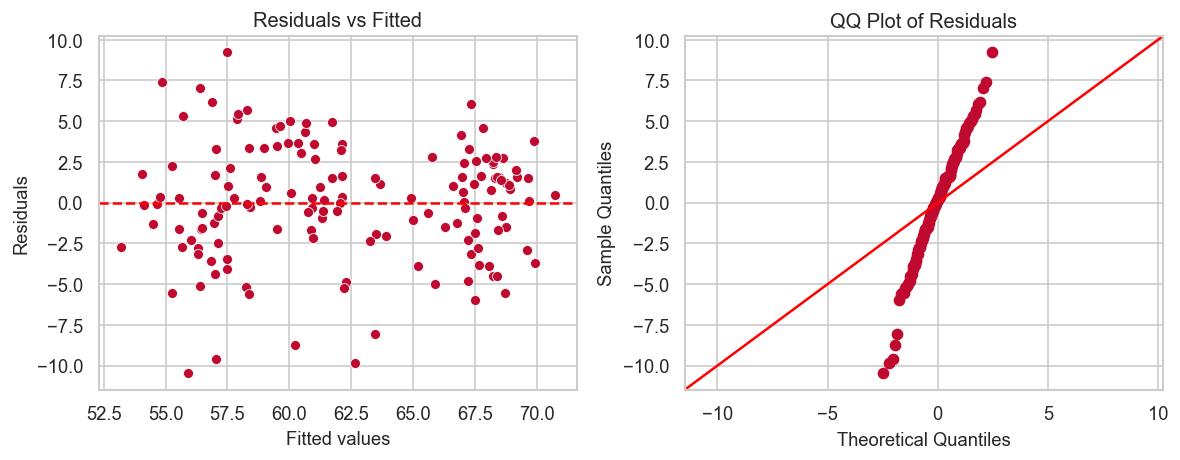


Variance Inflation Factor (VIF) for Tradeoff model:
             feature   VIF
0             log_MF 3.155
1            log_GHG 2.630
2  Global_region_num 1.586


In [60]:
model_formula_tradeoff = 'hale_birth ~ log_MF + log_GHG + Global_region_num + log_MF:Global_region_num'
ols_model_tradeoff = smf.ols(formula=model_formula_tradeoff, data=df_scaled).fit()
print(ols_model_tradeoff.summary())
# Residual plots
residuals_tradeoff = ols_model_tradeoff.resid
fitted_tradeoff = ols_model_tradeoff.fittedvalues
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.scatterplot(x=fitted_tradeoff, y=residuals_tradeoff, ax=axes[0])
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')
sm.qqplot(residuals_tradeoff, line='45', ax=axes[1])
axes[1].set_title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()
# Check multicollinearity
X_tradeoff = df_scaled[['log_MF', 'log_GHG', 'Global_region_num']]
vif_data_tradeoff = pd.DataFrame()
vif_data_tradeoff['feature'] = X_tradeoff.columns
vif_data_tradeoff['VIF'] = [variance_inflation_factor(X_tradeoff.values, i) for i in range(X_tradeoff.shape[1])]
print("\nVariance Inflation Factor (VIF) for Tradeoff model:")
print(vif_data_tradeoff)

Strong, positive relationship between material footprint and healthy life expectancy, consistent with the idea that economic / material advancement improves health outcomes. <br>
However, the interaction is negative, indicating that wealthier regions experience shallower gains in HALE from additional consumption → a clear “sustainability trade-off” pattern.<br>
The GHG term’s insignificance suggests emissions are not an independent driver of HALE once development is captured through MF.

## 3. Model improvements

### 3.1 Fix slight heteroskedasticity by applying robust standard errors

In [62]:
ols_model_robust = ols_model_tradeoff.get_robustcov_results(cov_type='HC3')
print(ols_model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:             hale_birth   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     75.29
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           3.17e-34
Time:                        16:34:19   Log-Likelihood:                -396.08
No. Observations:                 148   AIC:                             802.2
Df Residuals:                     143   BIC:                             817.2
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### 3.2 Incorporate non-linearity

In [74]:
df['log_MF_sq'] = df['log_MF'] ** 2
model_quad = smf.ols('hale_birth ~ log_MF + log_MF_sq + log_GHG + Global_region_num + log_MF:Global_region_num', data=df).fit(cov_type='HC3')

# Compare the simpler (linear) and extended (quadratic) model
f_test = model_quad.compare_f_test(ols_model_robust)
print("Shared quadratic vs Linear model:")
print(f"F-test statistic = {f_test[0]:.3f}, p-value = {f_test[1]:.3f}")

Shared quadratic vs Linear model:
F-test statistic = 3.452, p-value = 0.065


In [75]:
print(model_quad.summary())

                            OLS Regression Results                            
Dep. Variable:             hale_birth   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     63.57
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.56e-34
Time:                        16:52:44   Log-Likelihood:                -394.31
No. Observations:                 148   AIC:                             800.6
Df Residuals:                     142   BIC:                             818.6
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Quadratic term ( (log MF)² ) is negative and significant → the relationship between material footprint and HALE is non-linear.Low levels of consumption strongly raise health, but gains flatten as material use grows. <br>
F-test p = 0.065 → the quadratic term improves fit marginally at ≈ 10 % significance (level of weak evidence). The non-linear form is theoretically consistent and statistically plausible, so it remains useful to retain. <br>
Regional interaction (log MF × region) is no longer significant → differences in slope by region become less relevant once curvature is included. <br>

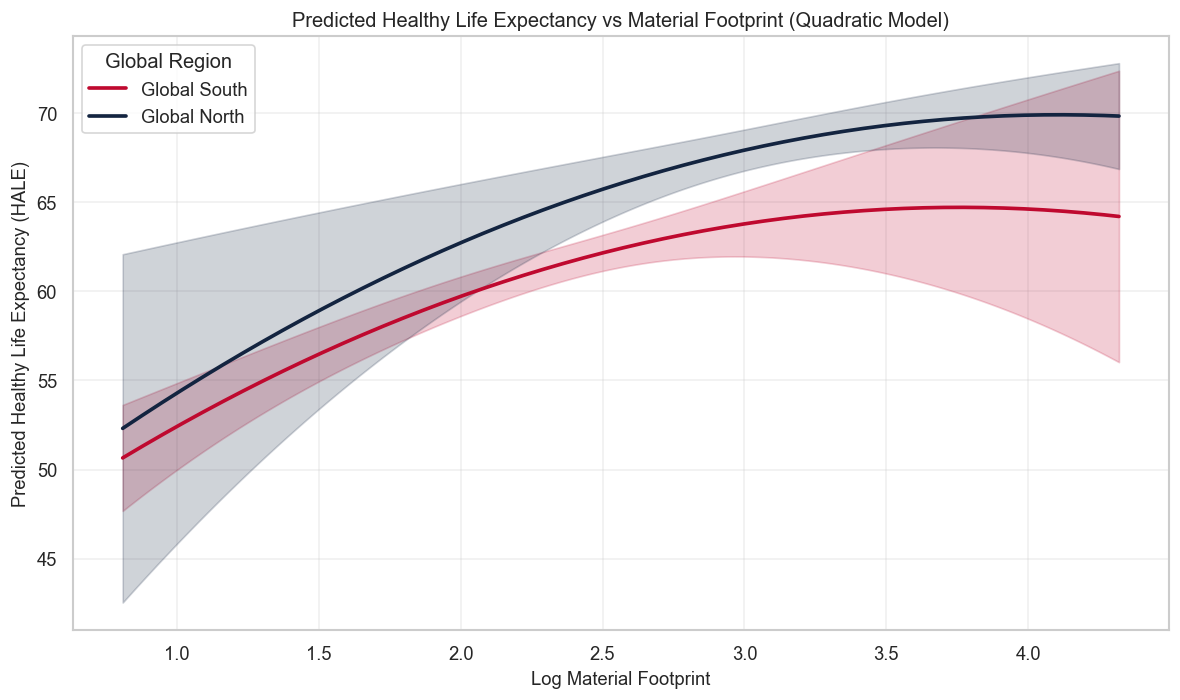

In [77]:
mf_range = np.linspace(df['log_MF'].min(), df['log_MF'].max(), 200)
pred_df = pd.DataFrame({
    'log_MF': np.tile(mf_range, 2),
    'log_MF_sq': np.tile(mf_range ** 2, 2),
    'log_GHG': df['log_GHG'].mean(),
    'Global_region_num': np.repeat([0, 1], len(mf_range))
})
pred_df['Global_region'] = np.where(pred_df['Global_region_num'] == 1,
                                    'Global North', 'Global South')

# Get predictions and confidence intervals
pred_res = model_quad.get_prediction(pred_df)
pred_summary = pred_res.summary_frame(alpha=0.05)  # 95% CI

# Merge predictions into dataframe
pred_df['Predicted_HALE'] = pred_summary['mean']
pred_df['lower'] = pred_summary['mean_ci_lower']
pred_df['upper'] = pred_summary['mean_ci_upper']

# Plot predicted curves with shaded CI
plt.figure(figsize=(10, 6))
for i, region in enumerate(['Global South', 'Global North']):
    subset = pred_df[pred_df['Global_region'] == region]
    plt.plot(subset['log_MF'], subset['Predicted_HALE'],
             color=COLORS[i], linewidth=2.2, label=region)
    plt.fill_between(subset['log_MF'], subset['lower'], subset['upper'],
                     color=COLORS[i], alpha=0.2)

plt.title('Predicted Healthy Life Expectancy vs Material Footprint (Quadratic Model)')
plt.xlabel('Log Material Footprint')
plt.ylabel('Predicted Healthy Life Expectancy (HALE)')
plt.legend(title='Global Region', loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

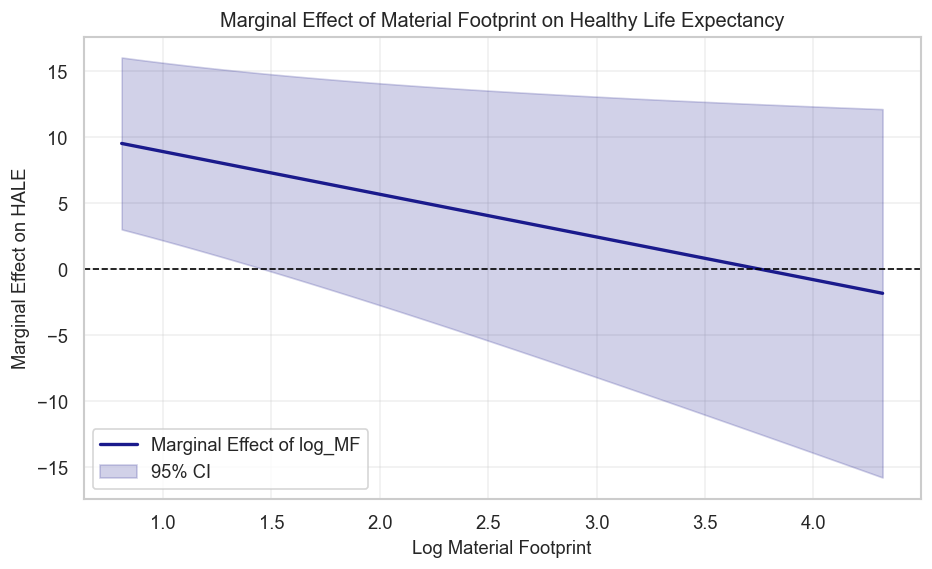

In [79]:
# Compute marginal effect (dy/dx = β1 + 2β2*log_MF)
b1 = model_quad.params['log_MF']
b2 = model_quad.params['log_MF_sq']

mf_seq = np.linspace(df['log_MF'].min(), df['log_MF'].max(), 200)
marginal_effect = b1 + 2 * b2 * mf_seq

# Optional: Add 95% confidence band (approximation)
se_b1 = model_quad.bse['log_MF']
se_b2 = model_quad.bse['log_MF_sq']
# Delta method variance of dy/dx
var_me = se_b1**2 + (2*mf_seq)**2 * se_b2**2
ci_upper = marginal_effect + 1.96 * np.sqrt(var_me)
ci_lower = marginal_effect - 1.96 * np.sqrt(var_me)

# Plot
plt.figure(figsize=(9, 5))
plt.plot(mf_seq, marginal_effect, color="#1a1a8c", lw=2, label='Marginal Effect of log_MF')
plt.fill_between(mf_seq, ci_lower, ci_upper, color="#1a1a8c", alpha=0.2, label='95% CI')
plt.axhline(0, color='black', linestyle='--', lw=1)
plt.xlabel('Log Material Footprint')
plt.ylabel('Marginal Effect on HALE')
plt.title('Marginal Effect of Material Footprint on Healthy Life Expectancy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The marginal-effect plot shows how the slope declines —
the line crossing toward zero indicates where gains from material use taper off.

### 3.3 Incoporate non-linearity to model 2.4

In [80]:
env_model_quad = smf.ols('log_GHG ~ log_MF + log_MF_sq + Global_region_num + log_MF:Global_region_num', data=df).fit(cov_type='HC3')

# Compare the simpler (linear) and extended (quadratic) model
f_test = env_model_quad.compare_f_test(ols_model_ghg)
print("Shared quadratic vs Linear model:")
print(f"F-test statistic = {f_test[0]:.3f}, p-value = {f_test[1]:.3f}")

Shared quadratic vs Linear model:
F-test statistic = 112.587, p-value = 0.000


In [81]:
print(env_model_quad.summary())

                            OLS Regression Results                            
Dep. Variable:                log_GHG   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     68.32
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           3.16e-32
Time:                        17:21:09   Log-Likelihood:                -95.102
No. Observations:                 148   AIC:                             200.2
Df Residuals:                     143   BIC:                             215.2
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Statistically and conceptually, curvature adds no insight — emissions rise almost linearly with consumption, confirming a proportional trade-off rather than an accelerating one.

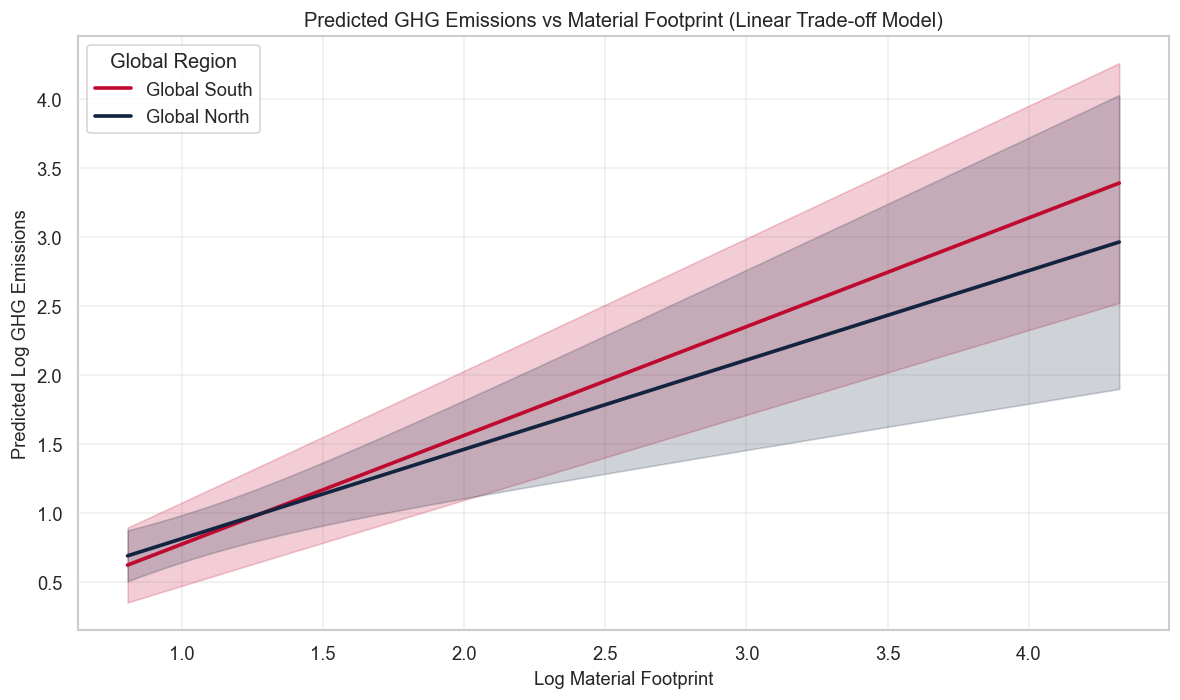

In [83]:
mf_range = np.linspace(df['log_MF'].min(), df['log_MF'].max(), 200)
pred_df = pd.DataFrame({
    'log_MF': np.tile(mf_range, 2),
    'Global_region_num': np.repeat([0, 1], len(mf_range))
})
pred_df['Global_region'] = np.where(pred_df['Global_region_num']==1, 'Global North', 'Global South')

# Predict + 95% CI
pred = ols_model_ghg.get_prediction(pred_df).summary_frame(alpha=0.05)
pred_df['pred']  = pred['mean']
pred_df['lower'] = pred['mean_ci_lower']
pred_df['upper'] = pred['mean_ci_upper']

# Plot
plt.figure(figsize=(10,6))
for i, region in enumerate(['Global South', 'Global North']):
    subset = pred_df[pred_df['Global_region']==region]
    plt.plot(subset['log_MF'], subset['pred'], color=COLORS[i], lw=2.2, label=region)
    plt.fill_between(subset['log_MF'], subset['lower'], subset['upper'], color=COLORS[i], alpha=0.2)

plt.title('Predicted GHG Emissions vs Material Footprint (Linear Trade-off Model)')
plt.xlabel('Log Material Footprint')
plt.ylabel('Predicted Log GHG Emissions')
plt.legend(title='Global Region', loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 4. (extra) Further work

### 4.1 Hierarchical model with income groups

In [84]:
# random intercepts and slopes for log_MF by income group
m_mixed = smf.mixedlm(
    "hale_birth ~ log_MF + log_MF_sq + log_GHG",
    data=df,
    groups=df["World Bank's income classification"], 
    re_formula="~log_MF"  # allow slope to vary by group
).fit()
print(m_mixed.summary())

# optional: extract region-specific slopes/intercepts
print(m_mixed.random_effects)

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  hale_birth
No. Observations:    148      Method:              REML      
No. Groups:          4        Scale:               11.0087   
Min. group size:     20       Log-Likelihood:      -390.9347 
Max. group size:     52       Converged:           No        
Mean group size:     37.0                                    
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          46.268                                    
log_MF             10.705                                    
log_MF_sq          -1.624                                    
log_GHG            -1.184    0.581 -2.040 0.041 -2.322 -0.046
Group Var           7.075                                    
Group x log_MF Cov -8.710                                    
log_MF Var         1

Fixed effects: <br>
log_MF is strongly positive (≈10.7): higher material footprint → higher health.<br>
log_MF_sq negative (≈–1.62): concave relationship → diminishing returns at high consumption.<br>
log_GHG negative (≈–1.18, p ≈ 0.04): higher emissions modestly harm or offset health gains.<br>

Random effects (group-level differences):<br>
High-income: slightly below expected baseline (–2.4 intercept), weaker slope (~3.0)<br>
Low-income: above baseline (+3.6 intercept), steep negative slope (~–4.4)<br>
Upper- and lower-middle income groups cluster near zero.<br>
The variance of group intercepts/slopes (Group Var, log_MF Var) confirms between-group heterogeneity, meaning relationships do vary by income level → supports H1c.<br>

The MF–HALE association is not uniform across development levels.
Health gains rise with material use, but the curve flattens sooner in wealthier economies — consistent with H1c that Global South (low-income) exhibits weaker or less predictable benefits per unit of material footprint.

### 4.2 Efficiency composite model

                            OLS Regression Results                            
Dep. Variable:           hale_ghg_eff   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     58.41
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           9.10e-33
Time:                        17:54:21   Log-Likelihood:                -433.07
No. Observations:                 148   AIC:                             878.1
Df Residuals:                     142   BIC:                             896.1
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

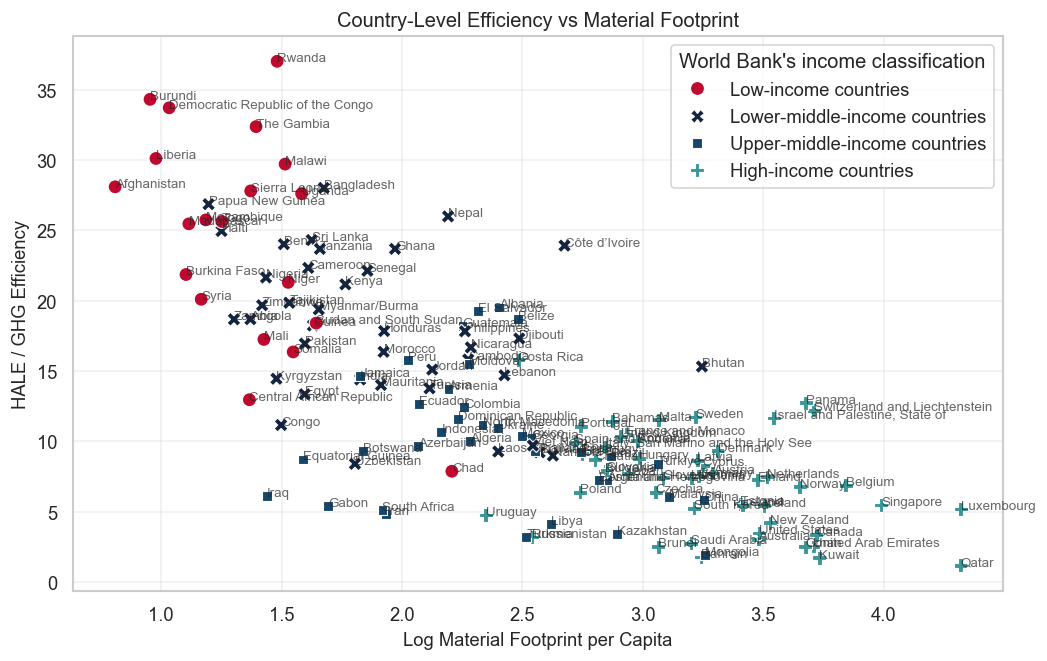

In [87]:
df["hale_ghg_eff"] = df["hale_birth"] / np.exp(df["log_GHG"])
m_eff = smf.ols('hale_ghg_eff ~ log_MF + log_MF_sq + Q("World Bank\'s income classification")', data=df).fit(cov_type='HC3')
print(m_eff.summary())

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='log_MF', y='hale_ghg_eff',
                hue='World Bank\'s income classification', style='World Bank\'s income classification', s=70)
for i, row in df.iterrows():
    plt.text(row['log_MF'], row['hale_ghg_eff'], row['CountryName'], fontsize=8, alpha=0.7)

plt.title("Country-Level Efficiency vs Material Footprint")
plt.xlabel("Log Material Footprint per Capita")
plt.ylabel("HALE / GHG Efficiency")
plt.grid(alpha=0.3)
plt.show()

R² ≈ 0.68 → good fit.<br>
log_MF negative (–7.99, p < 0.1): higher material use decreases health-per-emission efficiency.<br>
Low- and lower-middle-income groups have significantly higher efficiency (positive coefficients, p < 0.01 and p < 0.05).<br>
Upper-middle and high-income coefficients are not significant → efficiency plateaus at higher income.<br>

Lower-income countries achieve greater HALE per emission, reflecting more “efficient” resource use.
However, as MF rises, efficiency declines — suggesting diminishing sustainability returns.
This again aligns with H1c: the link between material use and health differs structurally between Global South and North.

# have left Anggie your work here~

## 4.2 Multicollinearity and Variable Significance

This step evaluates potential multicollinearity among predictors and identifies which variables significantly influence Healthy Life Expectancy (HALE). The correlation matrix highlights strong relationships among log-transformed variables (notably between log_MF and log_PPP), indicating possible collinearity. The sorted p-values from the OLS regression show that log_PPP, the North–South interaction, and the regional dummy (North_dummy) are statistically significant at the 1% level, while Under-5 Mortality is marginally significant.

In [58]:
df.describe()[['GHG','MF','HALE','Under5','PPP']]
df[['log_GHG','log_MF','log_PPP','Under5','North_dummy']].corr().round(2)



KeyError: "['HALE'] not in index"

In [ ]:
sig_table = hale_ols.pvalues.sort_values()
sig_table

## 4.3 Residual Diagnostics and Model Assumptions


To validate the regression assumptions, the residuals’ behavior are examined:

1.   Histogram (Residual distribution): confirms approximate normality
2.   QQ plot: points align near the 45° line, indicating limited deviation from normality.
3. Residuals vs Fitted values: the spread is random around zero, suggesting homoscedasticity (constant variance).

These diagnostics collectively support the robustness of the OLS model, though a slight right-tail skew may indicate mild heteroscedasticity. This is addressed in the following section through robust standard errors and Ridge regularization.

In [ ]:
resid = hale_fit.resid

# Residual Distribution
sns.histplot(resid, kde=True)
plt.title('Residuals (HALE model)')
plt.show()

# Normality Check (QQ plot)
sm.qqplot(resid, line='45', fit=True)
plt.title('QQ plot')
plt.show()

# Homoscedasticity Check (Residuals vs Fitted)
sns.scatterplot(x=hale_fit.fittedvalues, y=resid)
plt.axhline(0, ls='--', c='red')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()


## 4.4 Robustness and Ridge Regression

After detecting heteroscedasticity through the Breusch–Pagan test, the model is re-estimated using Ridge regression with standardization and log transformation to address both multicollinearity and variance instability. Ridge regularization helps stabilize coefficient estimates by shrinking them toward zero, improving reliability while maintaining interpretability.

### 4.4.1 Model Robustness Checks: Autocorrelation & Heteroscedasticity

In [ ]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# Durbin–Watson test (autocorrelation)
dw = durbin_watson(hale_fit.resid)
print(f"Durbin–Watson statistic: {dw:.3f}")
if 1.5 < dw < 2.5:
    print("No autocorrelation detected.")
else:
    print("Possible autocorrelation detected.")

# Breusch–Pagan test (heteroscedasticity)
bp_test = het_breuschpagan(hale_fit.resid, hale_fit.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(bp_labels, bp_test))
print("\nBreusch–Pagan test results:")
for k, v in bp_results.items():
    print(f"{k}: {v:.4f}")

if bp_results['p-value'] > 0.05:
    print("Homoscedasticity assumed (no heteroscedasticity).")
else:
    print("Heteroscedasticity detected — consider robust SE or Ridge correction.")

The Durbin–Watson test indicates no autocorrelation (DW = 1.76).
However, the Breusch–Pagan test yields a p-value below 0.05, confirming heteroscedasticity, which justifies applying robust standard errors or a regularized approach (Ridge).

### 4.4.2 Ridge Regression with Standardization and Log Transformation

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np, pandas as pd

X = df[['log_MF','log_PPP','Under5','North_dummy','interaction']].dropna()
y = df.loc[X.index, 'HALE']

ridge_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3,3,50)))
])
ridge_pipe.fit(X, y)
ridge = ridge_pipe.named_steps['ridge']

print("Best alpha:", ridge.alpha_)
print("R²:", ridge_pipe.score(X, y))

coef = pd.Series(ridge.coef_, index=X.columns)
coef

The model is re-estimated using RidgeCV with cross-validation and standardized predictors.
Optimal shrinkage (α) is automatically selected.
The resulting R² ≈ 0.60, similar to the OLS model, but Ridge provides more stable coefficients by penalizing over-influential variables.

### 4.4.3 Standardized Ridge Coefficients Visualization

In [ ]:
coef_df = pd.DataFrame({
    "Variable": list(coef.index),
    "Ridge Coefficient": coef.values
}).sort_values("Ridge Coefficient", ascending=False)

sns.barplot(data=coef_df, x="Ridge Coefficient", y="Variable", palette="viridis")
plt.title("Standardized Ridge Coefficients (HALE Model)")
plt.tight_layout()
plt.show()

The interaction term has the strongest positive influence on HALE, followed by economic capacity (log_PPP).
Negative coefficients for North_dummy, log_MF, and Under5 imply that higher material intensity and mortality correlate with lower life expectancy.
This confirms that structural inequality (captured by North–South interaction) remains a dominant driver of health outcomes.

### 4.4.4 VIF after Ridge Standardization

Variance Inflation Factor (VIF) values are recalculated after standardization.
Results show reduced multicollinearity compared to the OLS model, though the interaction and regional dummy remain relatively correlated, it is consistent with their conceptual overlap. Overall, the Ridge model provides a more reliable and interpretable fit under multicollinearity.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
X_std = StandardScaler().fit_transform(X)
X_std = sm.add_constant(X_std)
vif = pd.DataFrame({
    "Feature": ['const'] + list(X.columns),
    "VIF": [variance_inflation_factor(X_std, i) for i in range(X_std.shape[1])]
})
vif.sort_values("VIF", ascending=False)